# 専門用語抽出とNTM
author : nakamuraleon  
email : nakamuraleon0552@gmail.com  

### 1. Memo
Word-separation  
分かち書き（形態素解析）するマシンとして, MeCabとjanomeがある.
janomeはインストールが簡単. 各形態素の代表表記(名詞とか活用表記とか)が表示されるため, Twitterなどの表記揺れの多いものを解析するのに優れている. ただし, その分実行速度が長い.MeCabは実行速度と判別精度共に高い. 少しインストールがめんどくさい. 今回はjanomeを使用する. 


### 2. Dataset
特許データセット


### 3. Reference
http://gensen.dl.itc.u-tokyo.ac.jp/pytermextract/

## 1. Preaparing

In [172]:
# standard
import pandas as pd
import numpy as np
import random
import os
import collections
import time
import pickle

# termextract
import termextract.janome
import termextract.core

# gensim
import gensim
from gensim import corpora, models

# tqdm
# どちらかを実行する.
# from tqdm import tqdm
from tqdm import tqdm_notebook as tqdm

# janome
import janome
from janome import analyzer
from janome.charfilter import *
from janome.tokenfilter import *
from janome.tokenizer import Tokenizer

# torch
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.tensorboard import SummaryWriter

# sklearn
from sklearn.utils import shuffle

In [173]:
from torch import nn
import pickle
import gensim
import torch
import random
from torch.utils.tensorboard import SummaryWriter

## 4. Setting

In [174]:
class DataLoader(object):
    def __init__(self, data, bow_vocab, batch_size, shuffle=True):
        self.batch_size = batch_size
        self.bow_vocab = bow_vocab
        
        self.index = 0
        self.pointer = np.array(range(len(data)))
        
        self.data = np.array(data)
        self.bow_data = np.array([bow_vocab.doc2bow(s) for s in data])
        
        # counting total word number
        word_count = []
        for bow in self.bow_data:
            wc = 0
            for (i, c) in bow:
                wc += c
            word_count.append(wc)
        
        self.word_count = sum(word_count)
        self.data_size = len(data)
        
        self.shuffle = shuffle
        self.reset()

    
    def reset(self):
        if self.shuffle:
            self.pointer = shuffle(self.pointer)
        self.index = 0 
    
    
    # transform bow data into (1 x V) size vector.
    def _pad(self, batch):
        bow_vocab = len(self.bow_vocab)
        res_src_bow = np.zeros((len(batch), bow_vocab))
        
        for idx, bow in enumerate(batch):
            bow_k = [k for k, v in bow]
            bow_v = [v for k, v in bow]
            res_src_bow[idx, bow_k] = bow_v
            
        return res_src_bow
    
    def __iter__(self):
        return self

    def __next__(self):
        
        if self.index >= self.data_size:
            self.reset()
            raise StopIteration()
            
        ids = self.pointer[self.index: self.index + self.batch_size]
        batch = self.bow_data[ids]
        padded = self._pad(batch)
        tensor = torch.tensor(padded, dtype=torch.float, device=device)
        
        self.index += self.batch_size

        return tensor
    
    # for NTM.lasy_predict()
    def bow_and_text(self):
        if self.index >= self.data_size:
            self.reset()
            
        text = self.data[self.index: self.index + self.batch_size]
        batch = self.bow_data[self.index: self.index + self.batch_size]
        padded = self._pad(batch)
        tensor = torch.tensor(padded, dtype=torch.float, device=device)
        self.reset()

        return tensor, text

In [175]:
# cited : https://github.com/yuewang-cuhk/TAKG/blob/master/pykp/model.py
class NTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, topic_num,  l1_strength=0.001):
        super(NTM, self).__init__()
        self.input_dim = input_dim
        self.topic_num = topic_num
        self.fc11 = nn.Linear(self.input_dim, hidden_dim)
        self.fc12 = nn.Linear(hidden_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, topic_num)
        self.fc22 = nn.Linear(hidden_dim, topic_num)
        self.fcs = nn.Linear(self.input_dim, hidden_dim, bias=False)
        self.fcg1 = nn.Linear(topic_num, topic_num)
        self.fcg2 = nn.Linear(topic_num, topic_num)
        self.fcg3 = nn.Linear(topic_num, topic_num)
        self.fcg4 = nn.Linear(topic_num, topic_num)
        self.fcd1 = nn.Linear(topic_num, self.input_dim)
        self.l1_strength = torch.FloatTensor([l1_strength]).to(device)

    def encode(self, x):
        e1 = F.relu(self.fc11(x))
        e1 = F.relu(self.fc12(e1))
        e1 = e1.add(self.fcs(x))
        return self.fc21(e1), self.fc22(e1)

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu

    def generate(self, h):
        g1 = torch.tanh(self.fcg1(h))
        g1 = torch.tanh(self.fcg2(g1))
        g1 = torch.tanh(self.fcg3(g1))
        g1 = torch.tanh(self.fcg4(g1))
        g1 = g1.add(h)
        return g1

    def decode(self, z):
        d1 = F.softmax(self.fcd1(z), dim=1)
        return d1

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, self.input_dim))
        z = self.reparameterize(mu, logvar)
        g = self.generate(z)
        return z, g, self.decode(g), mu, logvar

    def print_topic_words(self, vocab_dic, fn, n_top_words=10):
        beta_exp = self.fcd1.weight.data.cpu().numpy().T
        
        print("Writing to %s" % fn)
        fw = open(fn, 'w')
        
        for k, beta_k in enumerate(beta_exp):
            topic_words = [vocab_dic[w_id] for w_id in np.argsort(beta_k)[:-n_top_words - 1:-1]]
            
            print('Topic {}: {}'.format(k, ' '.join(topic_words)))
            
            fw.write('{}\n'.format(' '.join(topic_words)))
        fw.close()
        print(beta_exp) #fai=softmax(beta_exp)
        

In [176]:
# https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html
# BCE
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, size_average=False)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# なぜL1正則化が使われているのか
# https://pytorch.org/docs/stable/generated/torch.nn.L1Loss.html
def l1_penalty(para):
    return nn.L1Loss()(para, torch.zeros_like(para))


def check_sparsity(para, sparsity_threshold=1e-3):
    num_weights = para.shape[0] * para.shape[1]
    num_zero = (para.abs() < sparsity_threshold).sum().float()
    return num_zero / float(num_weights)

def update_l1(cur_l1, cur_sparsity, sparsity_target):
    diff = sparsity_target - cur_sparsity
    cur_l1.mul_(2.0 ** diff)

def compute_loss(model, dataloader, optimizer, epoch):
    model.train()
    train_loss = 0
    
    for batch_idx, data_bow in enumerate(dataloader):
        data_bow = data_bow.to(device)
        
        # normalize data
        data_bow_norm = F.normalize(data_bow)
        optimizer.zero_grad()
        
        z, g, recon_batch, mu, logvar = model(data_bow_norm)
        
        loss = loss_function(recon_batch, data_bow, mu, logvar)
        loss = loss + model.l1_strength * l1_penalty(model.fcd1.weight)
        loss.backward() # https://zenn.dev/hirayuki/articles/bbc0eec8cd816c183408
        train_loss += loss.item()
        optimizer.step()
    
    sparsity = check_sparsity(model.fcd1.weight.data)
    print("Overall sparsity = %.3f, l1 strength = %.5f" % (sparsity, model.l1_strength))
    print("Target sparsity = %.3f" % target_sparsity)
    update_l1(model.l1_strength, sparsity, target_sparsity)
    
    avg_loss = train_loss / len(dataloader.data)
    
    print('Train epoch: {} Average loss: {:.4f}'.format(
        epoch, avg_loss))
    
    return sparsity, avg_loss

def compute_test_loss(model, dataloader, epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, data_bow in enumerate(dataloader):
            data_bow = data_bow.to(device)
            data_bow_norm = F.normalize(data_bow)

            z, _, recon_batch, mu, logvar = model(data_bow_norm)
            test_loss += loss_function(recon_batch, data_bow, mu, logvar).item()

    avg_loss = test_loss / len(dataloader.data)
    print('Test epoch : {} Average loss: {:.4f}'.format(epoch, avg_loss))
    return z, avg_loss


def compute_perplexity(model, dataloader):
    
    model.eval()
    loss = 0
    
    with torch.no_grad():
        for i, data_bow in enumerate(dataloader):
            data_bow = data_bow.to(device)
            data_bow_norm = F.normalize(data_bow)
            
            z, g, recon_batch, mu, logvar = model(data_bow_norm)
            
            #loss += loss_function(recon_batch, data_bow, mu, logvar).detach()
            loss += F.binary_cross_entropy(recon_batch, data_bow, size_average=False)
            
    loss = loss / dataloader.word_count
    perplexity = np.exp(loss.cpu().numpy())
    
    return perplexity


def lasy_predict(model, dataloader,vocab_dic, num_example=5, n_top_words=5):
    model.eval()
    docs, text = dataloader.bow_and_text()
    
    docs, text = docs[:num_example], text[:num_example]
    
    docs_device = docs.to(device)
    docs_norm = F.normalize(docs_device)
    z, _, _, _, _ = model(docs_norm)
    z_a = z.detach().cpu().argmax(1).numpy()
    z = torch.softmax(z, dim=1).detach().cpu().numpy()
    
    beta_exp = model.fcd1.weight.data.cpu().numpy().T
    topics = []
    for k, beta_k in enumerate(beta_exp):
        topic_words = [vocab_dic[w_id] for w_id in np.argsort(beta_k)[:-n_top_words - 1:-1]]
        topics.append(topic_words)
    
    for i, (zi, _z_a, t) in enumerate(zip(z, z_a, text)):
        
        print('\n===== # {}, Topic : {}, p : {:.4f} %'.format(i+1, _z_a,  zi[_z_a] * 100))
        print("Topic words :", ', '.join(topics[_z_a]))
        print("Input :", ' '.join(t))
        
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.kaiming_uniform(m.weight)

In [178]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# set random seeds
random.seed(123)
torch.manual_seed(123)

num_articles = -1

# data size limitation
max_src_len = 150
max_trg_len = 10
max_bow_vocab_size=100000

# Model parameter
hidden_dim = 1000 
topic_num = 15
target_sparsity=0.85

# Training parameter
batch_size = 32
learning_rate = 0.001
logdir = "./"
n_epoch = 200

## 2, 3. Loading File (Load dictionary)

In [179]:
def loadfile(period):
    f = open('./Dataset/'+str(period)+'_docsfile.txt', 'rb')
    dicts = pickle.load(f)
    return dicts[:500]

## 5. Training

In [181]:
period = 2000
dicts = loadfile(period)
dicts = dicts[:500]
bow_vocab = gensim.corpora.Dictionary(dicts)
bow_vocab_size = len(bow_vocab)
test_valid_size = int(len(dicts) * 0.1)
test_data  = dicts[:test_valid_size]
valid_data = dicts[test_valid_size : test_valid_size*2]
train_data = dicts[test_valid_size*2 :]

In [182]:
# Tensorboard
writer = SummaryWriter()

# building dataloader
dataloader = DataLoader(data = train_data, bow_vocab = bow_vocab, batch_size = batch_size)
dataloader_valid = DataLoader(data = valid_data, bow_vocab = bow_vocab, batch_size = batch_size, shuffle=False)

# builing model and optimiser
ntm_model = NTM(input_dim = bow_vocab_size, hidden_dim = hidden_dim, topic_num = topic_num, l1_strength=0.0000001).to(device)
optimizer = optim.Adam(ntm_model.parameters(), lr=learning_rate)

ntm_model.apply(init_weights)


# Start Training
for epoch in range(1, n_epoch + 1):
    
    print("======== Epoch", epoch, " ========")
    sparsity, train_loss = compute_loss(ntm_model, dataloader, optimizer, epoch)
    z, val_loss = compute_test_loss(ntm_model, dataloader_valid, epoch)
    
    pp = compute_perplexity(ntm_model, dataloader)
    pp_val = compute_perplexity(ntm_model, dataloader_valid)
    print("PP(train) = %.3f, PP(valid) = %.3f" % (pp, pp_val))
    
    writer.add_scalars('scalar/loss',{'train_loss': train_loss,'valid_loss': val_loss},epoch)
    writer.add_scalars('scalar/perplexity',{'train_pp': pp,'valid_pp': pp_val},epoch)
    writer.add_scalars('scalar/sparsity',{'sparsity': sparsity},epoch)
    writer.add_scalars('scalar/l1_strength',{'l1_strength': ntm_model.l1_strength},epoch)

    if epoch % 50 == 0:
        ntm_model.print_topic_words(bow_vocab, os.path.join(logdir, 'topwords_e%d.txt' % epoch))
        lasy_predict(ntm_model, dataloader_valid, bow_vocab, num_example=10, n_top_words=10)
        
writer.close()

<ipython-input-174-6cefa275ff45>:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.data = np.array(data)
<ipython-input-174-6cefa275ff45>:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.bow_data = np.array([bow_vocab.doc2bow(s) for s in data])
<ipython-input-176-9c8d674ef505>:117: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  torch.nn.init.kaiming_uniform(m.weight)


======== Epoch 1  ========


c:\Users\err09\anaconda3\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Overall sparsity = 0.002, l1 strength = 0.00000
Target sparsity = 0.850
Train epoch: 1 Average loss: 2186.5968
Test epoch : 1 Average loss: 2496.3438
PP(train) = 44793.992, PP(valid) = 40435.941
======== Epoch 2  ========
Overall sparsity = 0.002, l1 strength = 0.00000
Target sparsity = 0.850
Train epoch: 2 Average loss: 2116.4983
Test epoch : 2 Average loss: 2496.4084
PP(train) = 40804.227, PP(valid) = 39318.809
======== Epoch 3  ========
Overall sparsity = 0.002, l1 strength = 0.00000
Target sparsity = 0.850
Train epoch: 3 Average loss: 2091.8175
Test epoch : 3 Average loss: 2483.0555
PP(train) = 37656.707, PP(valid) = 38727.727
======== Epoch 4  ========
Overall sparsity = 0.002, l1 strength = 0.00000
Target sparsity = 0.850
Train epoch: 4 Average loss: 2079.4357
Test epoch : 4 Average loss: 2478.1704
PP(train) = 36312.457, PP(valid) = 37943.512
======== Epoch 5  ========
Overall sparsity = 0.002, l1 strength = 0.00000
Target sparsity = 0.850
Train epoch: 5 Average loss: 2072.4824
T

In [274]:
def compute_test_loss2(model, dataloader):
    model.eval()
    # test_loss = 0
    zall = torch.tensor([])
    with torch.no_grad():
        for i, data_bow in enumerate(dataloader):
            data_bow = data_bow.to(device)
            data_bow_norm = F.normalize(data_bow)
            z, _, recon_batch, mu, logvar = model(data_bow_norm)
            # test_loss += loss_function(recon_batch, data_bow, mu, logvar).item()
            zall = torch.cat((zall, z), 0)
    return zall

zall = compute_test_loss2(ntm_model, dataloader)

In [284]:
def get_mean(x, topic, num):
    for i in range(15):
        i = topic == num
        return np.mean(x[i], axis=0)

In [273]:
z_test

tensor([[-0.9370,  0.0414, -1.0193,  ..., -0.3663,  0.2173, -0.6077],
        [ 4.7012, -1.4832, -1.4309,  ...,  2.8254,  0.5152,  0.0310],
        [ 1.8821, -0.2961,  0.0430,  ..., -0.7473,  0.7476, -0.4400],
        ...,
        [ 4.1272,  0.3572,  0.3461,  ...,  1.8333,  3.9838, -1.4907],
        [-4.8689,  0.5898, -0.0346,  ..., -1.0902,  0.3416,  1.4811],
        [-0.1099, -1.0022,  0.0601,  ..., -0.7251, -0.2561, -0.4016]])

In [278]:
zall

tensor([[-0.8590,  0.0539,  0.7744,  ..., -0.0592,  3.2416, -0.4803],
        [-0.8966,  0.0747,  0.2278,  ..., -0.6816,  0.6067,  0.3539],
        [ 1.8821, -0.2961,  0.0430,  ..., -0.7473,  0.7476, -0.4400],
        ...,
        [-0.7526,  1.2902, -0.5081,  ...,  0.0645,  2.3945, -1.0239],
        [-5.7462,  0.1843,  0.4222,  ..., -0.2218, -5.9993,  0.0257],
        [-1.5934, -1.1442, -0.4781,  ...,  0.8418,  1.2358,  0.9038]])

c:\Users\err09\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\err09\anaconda3\lib\site-packages\numpy\core\_methods.py:162: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


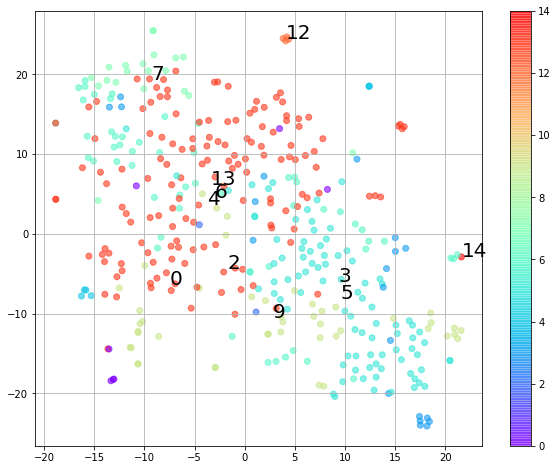

In [285]:
import pickle
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

#t-SNEで次元削減
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state = 1, n_iter = 1000)
x = tsne.fit_transform(zall)

# z_mu = compute_test_loss2(ntm_model, dataloader)
# z_mu
zsoft = torch.softmax(zall , dim=1).detach().cpu().numpy()
topic = []
for i in zsoft:
    topic.append(np.argmax(i))
topic = np.array(topic)

# plt.legend(fontsize = 30)
plt.figure(figsize=(10, 8)) 
plt.scatter(x[:, 0], x[:, 1], c=topic, cmap="rainbow", alpha=0.6)
# plt.scatter(x[:, 0], x[:, 1], cmap="rainbow", alpha=0.6)
for i in range(15):
    m = get_mean(x, topic, i)
    plt.text(m[0], m[1], "{}".format(i), fontsize=20)

plt.colorbar()
plt.grid()

## 補足

In [11]:
%%time
# 構築したモデルの保存
filename = 'model.pkl'
pickle.dump(ntm_model,open(filename,'wb'))

Wall time: 360 ms


In [16]:
%%time
# 保存したモデルの読み込み
model = pickle.load(open(filename, 'rb'))

Wall time: 257 ms


In [19]:
model.state_dict()

OrderedDict([('fc11.weight',
              tensor([[-0.0091, -0.0057, -0.0048,  ..., -0.0157, -0.0144, -0.0032],
                      [ 0.0031,  0.0066,  0.0011,  ...,  0.0029,  0.0034, -0.0033],
                      [ 0.0061,  0.0173, -0.0045,  ..., -0.0058, -0.0109, -0.0076],
                      ...,
                      [-0.0089, -0.0102,  0.0064,  ..., -0.0179, -0.0150,  0.0069],
                      [-0.0047,  0.0101,  0.0030,  ..., -0.0163, -0.0004, -0.0037],
                      [-0.0026,  0.0105, -0.0010,  ..., -0.0066, -0.0076,  0.0103]])),
             ('fc11.bias',
              tensor([ 1.0366e-02, -1.2953e-02,  5.3759e-03, -1.1088e-02, -1.2346e-02,
                       9.4875e-03,  8.1956e-04, -1.5900e-02,  3.7195e-03,  2.2818e-03,
                      -1.5782e-02,  6.1309e-03, -8.7774e-03, -9.4262e-03, -9.6393e-03,
                      -1.0552e-02,  1.4730e-02,  1.1436e-02,  5.2312e-03,  5.6969e-03,
                       2.2054e-03, -1.6879e-02,  1.0071e-02,  

In [22]:
model.T_destination

~T_destination

In [25]:
model.children

<bound method Module.children of NTM(
  (fc11): Linear(in_features=36616, out_features=1000, bias=True)
  (fc12): Linear(in_features=1000, out_features=1000, bias=True)
  (fc21): Linear(in_features=1000, out_features=20, bias=True)
  (fc22): Linear(in_features=1000, out_features=20, bias=True)
  (fcs): Linear(in_features=36616, out_features=1000, bias=False)
  (fcg1): Linear(in_features=20, out_features=20, bias=True)
  (fcg2): Linear(in_features=20, out_features=20, bias=True)
  (fcg3): Linear(in_features=20, out_features=20, bias=True)
  (fcg4): Linear(in_features=20, out_features=20, bias=True)
  (fcd1): Linear(in_features=20, out_features=36616, bias=True)
)>

In [32]:
model.train

<bound method Module.train of NTM(
  (fc11): Linear(in_features=36616, out_features=1000, bias=True)
  (fc12): Linear(in_features=1000, out_features=1000, bias=True)
  (fc21): Linear(in_features=1000, out_features=20, bias=True)
  (fc22): Linear(in_features=1000, out_features=20, bias=True)
  (fcs): Linear(in_features=36616, out_features=1000, bias=False)
  (fcg1): Linear(in_features=20, out_features=20, bias=True)
  (fcg2): Linear(in_features=20, out_features=20, bias=True)
  (fcg3): Linear(in_features=20, out_features=20, bias=True)
  (fcg4): Linear(in_features=20, out_features=20, bias=True)
  (fcd1): Linear(in_features=20, out_features=36616, bias=True)
)>

In [34]:
model.reparameterize()

TypeError: reparameterize() missing 2 required positional arguments: 'mu' and 'logvar'

In [ ]:
model

## 6. Performance Evaluation

In [183]:
dataloader_test  = DataLoader(data = test_data, bow_vocab = bow_vocab, batch_size = batch_size, shuffle=False)
pp_test = compute_perplexity(ntm_model, dataloader_test)
print("PP(test) = %.3f" % (pp_test))

PP(test) = 16469.613


<ipython-input-174-6cefa275ff45>:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.data = np.array(data)
<ipython-input-174-6cefa275ff45>:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.bow_data = np.array([bow_vocab.doc2bow(s) for s in data])


In [184]:
ntm_model.print_topic_words(bow_vocab, os.path.join(logdir, 'topwords_e%d.txt' % 9999))

Writing to ./topwords_e9999.txt
Topic 0: テーブル ワイヤ スパン 軸芯 検出精度 一対 置部 四つ ドライバー等 木質トラス
Topic 1: 型枠 鉄筋 現場 工程 配筋 モーメント 工期 双方 梁 径
Topic 2: 問題点 種 ロ 実施例 上記実施例 表面 イ ハ 設置 説明図
Topic 3: 建物 スパン 電波 付加機能 一般 上記実施 上記課題 履歴 電話交換機 程度
Topic 4: 内面 隔壁 設備 材 前記コンクリート 下部 維持管理 縦断面図 外面 コンクリート
Topic 5: 図面 説明 上記 形態 技術分野 課題 図 実施形態 効果 符号
Topic 6: 上部 ｄ ｃ 側面図 作業 上面 実施形態 種 ｂ 両側
Topic 7: 架構 地震 モーメント 降伏点鋼 溶接等 鉛直荷重 鉛直面 剛性 鋼材 接合部
Topic 8: 水底 一定間隔 後部 左 台船 リミットスイッチ 同上 ウインチ ワイヤ レーン材打設装置
Topic 9: － 特開平 号公報 トンネル 掘削 直径 後方 Ｂ 地山 周面
Topic 10: 内面 応力 径 外周面 隙間 添付図面 ナット 鉄筋 溶接 周面
Topic 11: 例 材料 建築物 種々 構造 図 技術分野 機能 断面図 課題
Topic 12: 断面図 両端 周面 ｃ 参照 ｂ ナット軸芯回り 丸太横断面 取り付け状態 要部斜視図
Topic 13: 部材 力 一端 移動 方向 形状 間隔 斜視図 上下 内側
Topic 14: 効率 程度 木材 該記入 対照 他物 上述 ドライバー等 前記 相当
[[-3.17032004e-06 -3.09057305e-06 -7.92671108e-06 ... -1.90304163e-05
  -2.87335715e-05 -2.94996498e-05]
 [ 4.32012894e-06 -7.81384460e-06  8.76874128e-06 ... -8.51316145e-05
  -1.42992343e-04 -1.24149941e-04]
 [ 5.77977971e-06 -3.67505982e-06 -5.97566532e-06 ... -8.67895778e-06
   9.

## 7. Predict

In [185]:
lasy_predict(ntm_model, dataloader_test, bow_vocab, num_example=50, n_top_words=10)


===== # 1, Topic : 13, p : 16.1276 %
Topic words : 部材, 力, 一端, 移動, 方向, 形状, 間隔, 斜視図, 上下, 内側
Input : 破壊 孔 破壊電極 進行方向 衝撃波 内部 図 破壊対象 挿入物 電解液 内部形状 プラズマ破壊方法 プラズマ破壊装置 上記発明 発明 形状 反射衝撃波 すり鉢状 回転楕円体 軸方向 上記孔 断面図 上記衝撃波 実施 パルスパワー源 上記内部形状 対数螺旋形状 形態 側方 上記進行方向制御手段 孔加工手段 孔内部 構成 所望 破壊力 焦点 挿入物配置手段 先端 コンデンサバンク 同軸ケーブル エネルギー 方向 楕円体 境目 液 効率 破壊方法 ～（ｃ 電極 反射 岩石 手段 法線方向 側面 すり鉢形状 平面衝撃波 壁面 部分 ラプチャーディスク すり鉢状部分 ａ すり鉢 上記挿入物 破壊対象自体 孔底面 進行方向制御手段 上記破壊対象自体 底部 容器状 上記電解液 上記境目 上記回転楕円体 接地電極 箇所 向き 奥 層状 圧力 技術 角度 導電体 絶縁体 制御 加工 中央部 回転楕円形 特定方向 略回転楕円体 導線部分 外周部 構造 日本規格協会 説明 スイッチ 電荷 破損 他方 凸 音速 底 配置 方位 範囲 先端付近 電解液層状注入手段 装置 動作原理 図示省略 遮蔽層 放電 放電エネルギー 寿命化 円錐状 原理 干渉縞 高山和喜 破裂弁 特許請求 孔あけ 先端形状 円錐形状 上記目的 上記ラプチャーディスク 上記実施 回路 電源 ｂ ロス 上述 曲面 転換 屈折 特性 所望形状 円柱形状 特定 一定 対数螺旋流路 ｃ 筐体 中央部分 遷移図 概念図 断面構造 中心部分 周囲 ドリル 水 課題 出口 斜め 中空部分 既知 参照 フォーカス 内側 渦 文献 はなし ｐ ～ 意味 一方向 矢印 近傍 圧力増幅率 干渉 自体 円錐 衝撃圧力 問題点 発生点 技術分野 特開平 号公報 形 衝撃 周辺機器 目的 一定角度 － 概要 車体 片側 極 電位差 内面 固体 穴 例 上方 挙動 順 下方 曲線 下端 一般 集中 抑制 任意 意義 母線 種類 比重 差 角 rupture disc 内壁 空間 媒体 例示 均等 変更 効果 図面 様子 符号

===== # 2, Top